<a href="https://colab.research.google.com/github/Koruvika/CV-Project/blob/main/DeMakeup_ImageDomainConversation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Giới thiệu **Image Domain Conversation**

**Image Domain Conversation** là lĩnh vực chuyển một hình ảnh từ vùng này (vùng ở đây mang nghĩa khá chung chung, có thể là vùng giá trị hoặc vùng ý nghĩa...) sang vùng khác.

Nghĩa là đầu vào của mô hình IDC là hình và đầu ra của nó cũng là một hình.

# UNET


In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, Model

import os
import cv2
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def downsampling(filters, kernel_size, apply_batch=True):
    result = keras.models.Sequential()
    result.add(layers.Conv2D(filters, kernel_size, 2, 'same', use_bias=False))
    if apply_batch:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsampling(filters, kernel_size, apply_dropout=False):
    result = keras.models.Sequential()
    result.add(layers.Conv2DTranspose(filters, kernel_size, 2, 'same', use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.4))
    result.add(layers.ReLU())
    return result

def create_UNet():
    inputs = layers.Input(shape=(256,1024,3))
    downstack = [
        downsampling(64,  4, apply_batch=False),
        downsampling(128, 4),
        downsampling(256, 4),
        downsampling(512, 4),
        downsampling(512, 4)
    ]
    upstack = [
        upsampling(512, 4, apply_dropout=True),
        upsampling(256, 4, apply_dropout=True),
        upsampling(128, 4, apply_dropout=True),
        upsampling(64,  4)
    ]
    last = layers.Conv2DTranspose(3, 4, 2, 'same', activation='tanh')
    
    concat = layers.Concatenate()

    inputs = layers.Input(shape=[256,1024,3])
    x = inputs

    skips = []
    for down in downstack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(upstack, skips):
        x = up(x)
        x = concat([x, skip])
    
    x = last(x)
    return Model(inputs, x)

# De-Makeup Project

## Workflow
- Tải makeup-data
- Đọc từng file, sau đó chia ảnh thành 3 phần, chỉ lấy 2 phần sau (phần thứ 2 là demakeup, phần thứ 3 là makeup)
- Xử lí dữ liệu và tạo train, val, test dataset.
- Xây dựng model Res50-UNet
- Xây dựng Perceptual Loss
- Xây dựng PSNR Metric
- Chạy mô hình, kiểm tra kết quả


## Tải makeup-data

In [3]:
!pip install --upgrade --no-cache-dir gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=f4b1c69ad61bfc3caf980a4494f66e46f7f87b4d1dcb7fef1d7f8faf180bcce4
  Stored in directory: /tmp/pip-ephem-wheel-cache-j1pvcez4/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [4]:
!gdown 1y333j9Aqf-kxLOHYReMankKCl309EObA

Downloading...
From: https://drive.google.com/uc?id=1y333j9Aqf-kxLOHYReMankKCl309EObA
To: /content/makeup_data.zip
100% 273M/273M [00:01<00:00, 177MB/s]


In [5]:
!unzip -q /content/makeup_data.zip -d /content/makeup_data 

## Trực quan hóa, xử lí dữ liệu và xây dựng tập dữ liệu huấn luyện, đánh giá

In [6]:
def show_img(path):
    img = plt.imread(path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

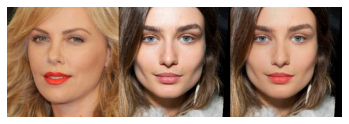

In [7]:
show_img("/content/makeup_data/makeup_data/train/0.png")

In [8]:
img = plt.imread("/content/makeup_data/makeup_data/train/10.png")
img.shape

(246, 768, 3)

In [9]:
"""Khai báo tham số batchsize, shape image phù hợp 
với model các bạn sẽ xây dựng và đường dẫn đến data 
chứa 3 folder train, test và val"""

BATCH_SIZE  = 1
IMG_HEIGHT  = 256
IMG_WIDTH   = 256
IMG_CHANNEL = 3

# Path tới folder de-makeup data 
IMG_PATH = "/content/makeup_data/makeup_data"
BUFFER_SIZE = BATCH_SIZE*10

In [10]:
def load(image_file):
    """Thực hiện các bước load ảnh và xử lý ảnh cơ bản
    Parameters
    ----------
    image_file : string 
        Path dẫn đến file ảnh.

    Returns
    -------
    input_image: tf.Tensor (tf.float32)
        ảnh input cho model (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target cho model (ảnh face chưa makeup).
    """
    
    # read file và decode ảnh
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image)
    
    # Split mỗi image tensor thành 2 tensors (2 ảnh):
    # - non-makeup image
    # - makeup image
    # chia ảnh làm 3 phần bằng nhau và chỉ lấy phần ảnh thứ 2 (ảnh chưa makeup) (target_image)
    # và thứ 3 (ảnh đã makeup) (input_image)
    _, target_image, input_image = tf.split(image, 3, 1)
    
    # resize input_image và target_image theo size đã define ở trên
    input_image = tf.image.resize(input_image, (IMG_HEIGHT, IMG_WIDTH))
    target_image = tf.image.resize(target_image, (IMG_HEIGHT, IMG_WIDTH))
    
    # Convert cả 2 images, input_image và target_image thành float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)
    
    return input_image, target_image

(256, 256, 3)


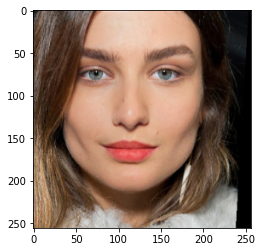

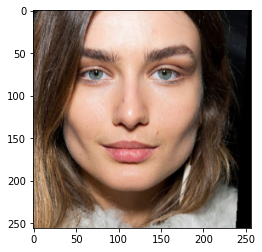

In [11]:
# test load function
input_image, target_image = load(str(IMG_PATH + '/train/0.png'))
print(input_image.shape)

plt.figure()
plt.imshow(input_image/255.0)
plt.figure()
plt.imshow(target_image/255.0)

In [12]:
@tf.function()
def random_flip(input_image, target_image):
    """Thực hiện random 50% flip sang trái hoặc phải
    Parameters
    ----------
    input_image: tf.Tensor (tf.float32)
        ảnh input cho model (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target cho model (ảnh face chưa makeup).

    Returns
    -------
    input_image: tf.Tensor (tf.float32)
        ảnh input cho model đã random flip trái hoặc phải (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target cho model đã random flip trái hoặc phải (ảnh face chưa makeup).
    """
    # tỉ lệ random 50% flip sang trái hoặc phải
    if tf.random.uniform(()) < 0.5:
        input_image = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)

    return input_image, target_image

    
def processing_image(input_image, target_image):
    """Tiền xử lý  ảnh trước khi đưa vào model, kỹ thuật xử lý ảnh này sẽ tùy thuộc vào pretrained model 
    mà người lập trình lựa chọn.
    Parameters
    ----------
    input_image: tf.Tensor (tf.float32)
        ảnh input cho model (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target cho model (ảnh face chưa makeup).

    Returns
    -------
    input_image: tf.Tensor (tf.float32)
        ảnh input đã qua tiền xử lý 
    target_image: tf.Tensor (tf.float32)
        ảnh target đã qua tiền xử lý
    """
    # tiền xử lý input_image
    input_image = keras.applications.resnet50.preprocess_input(input_image)
    # tiền xử lý target_image
    target_image /= 255.0 

    return input_image, target_image


def load_image_train(image_file):
    """Thực hiện xử lý ảnh để đưa vào model để train
    Parameters
    ----------
    input_image: tf.Tensor (tf.float32)
        ảnh input cho model (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target cho model (ảnh face chưa makeup).

    Returns
    -------
    input_image: tf.Tensor (tf.float32)
        ảnh input đã xử lý cho model để train (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target đã xử lý cho model để train (ảnh face chưa makeup).
    """
    # dùng hàm load để load ảnh 
    input_image, target_image = load(image_file)

    # dùng hàm random_flip để augment ảnh 
    input_image, target_image = random_flip(input_image, target_image)
    
    # dùng hàm processing_image để xử lý ảnh
    input_image, target_image = processing_image(input_image, target_image)
    
    return input_image, target_image


def load_image_val(image_file):
    """Thực hiện xử lý ảnh để đưa vào model thực hiện validation hoặc test
    Parameters
    ----------
    input_image: tf.Tensor (tf.float32)
        ảnh input cho model (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target cho model (ảnh face chưa makeup).

    Returns
    -------
    input_image: tf.Tensor (tf.float32)
        ảnh input đã xử lý cho model  (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target đã xử lý cho model (ảnh face chưa makeup).
    """
    # dùng hàm load để load ảnh  
    input_image, target_image = load(image_file)   
    
    # dùng hàm processing_image để xử lý ảnh
    input_image, target_image = processing_image(input_image, target_image)
    
    return input_image, target_image

In [13]:
train_dataset = tf.data.Dataset.list_files(str(IMG_PATH + '/train/*.png'))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
val_dataset = tf.data.Dataset.list_files(str(IMG_PATH + '/val/*.png'))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [15]:
test_dataset = tf.data.Dataset.list_files(str(IMG_PATH + '/test/*.png'))
test_dataset = test_dataset.map(load_image_val)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Xây dựng mô hình

In [16]:
class BuildRes50Unet():
    def __init__(self):
        """Khai báo 2 attribute của class chứa layer name của backbone
        Attributes
        ----------
        self.encoder_blocks_name: list
            list tên các layer trong pretrained model được lấy ra tham gia vào encoder 
        self.bridge_block_name: list
            tên layer trong pretrained model được lấy ra tham gia vào thành phần bridge của Unet 
        """
        # khai báo self.encoder_blocks_name
        self.encoder_blocks_name = ["input_1", "conv1_relu", "conv2_block3_out", "conv3_block4_out", "conv4_block6_out"] # (256, 3), (128,64), (64,256), (32,512), (16,1024)
        # khai báo self.bridge_block_name
        self.bridge_block_name = ["conv5_block3_out"] # 8, 8, 8
        
    
    def conv_block(self, inputs, num_filters):
        """Thực hiện 2 lần convolution liên tiếp 
        Parameters
        ----------
        inputs: tf.Tensor 
            tensor đi qua các layer trong model
        num_filters: int 
            số lượng filters

        Returns
        -------
        x: tf.Tensor 
            kết quả inputs đi qua 2 convlution block (Conv2D, BatchNormalization, Activation function)
        """
        
        # sử dụng Conv2D (filters=num_filters, kernel_size=(3,3), padding="same")
        # convolution block 1
        x = layers.Conv2D(num_filters, 3, 1, 'same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        # sử dụng Conv2D (filters=num_filters, kernel_size=(3,3), padding="same")
        # convlution block 2
        x = layers.Conv2D(num_filters, 3, 1, 'same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        
        return x
        
    
    
    def upsample_concate_block(self, inputs, skip_connection, num_filters):
        """Thực hiện Upsampling, skip connection và đi qua 2 convolution block
        Parameters
        ----------
        inputs: tf.Tensor 
            tensor đi qua các layer trong model
        skip_connection: tf.Tensor 
            tensor thực hiện skip connection 
        num_filters: int 
            số lượng filters

        Returns
        -------
        x: tf.Tensor 
            kết quả inputs upsampling saud đó concatenate với skip connection 
            rồi đi qua 2 convlution block
        """
        
        # Upsampling 
        x = layers.Conv2DTranspose(num_filters, 4, 2, 'same')(inputs)
        # Concatenate tensor đã upsample và skip connection
        x = layers.Concatenate()([x, skip_connection])
        # dùng method self.conv_block để đi qua 2 convoution blocks
        x = self.conv_block(x, num_filters)
        return x

    
    
    def build_model(self, input_shape):
        """Build Unet architecture sử dụng pretrained backbone (encoder)
        Parameters
        ----------
        input_shape: Tuple  
            shape input cuả model 
            
        Returns
        -------
        model: tf.keras.Model
            Unet model 
        """
        # khai báo input layer 
        inputs = layers.Input(shape = (IMG_HEIGHT, IMG_WIDTH, 3), name='input_1')
        
        # encoder
        ## get pretrained backbone (loại bỏ top, weight dùng imagenet, input là input tensor ở trên)
        resnet50 = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
        
        ## lấy 4 output tensor theo tên các layer trong self.encoder_blocks_name
        s1 = resnet50.get_layer(self.encoder_blocks_name[1]).output
        s2 = resnet50.get_layer(self.encoder_blocks_name[2]).output
        s3 = resnet50.get_layer(self.encoder_blocks_name[3]).output
        s4 = resnet50.get_layer(self.encoder_blocks_name[4]).output
        
        # bridge: lấy output tensor theo tên các layer trong self.bridge_block_name 
        b0 = resnet50.get_layer(self.bridge_block_name[0]).output
        
        # decoder
        ## dùng method upsample_concate_block để upsampling, concatenate skip connection
        ## và đi qua 2 convolutional block. Thực hiện với 4 output tensor ở encoder
        d1 = self.upsample_concate_block(b0, s4, 512) # 16
        d2 = self.upsample_concate_block(d1, s3, 256) # 32
        d3 = self.upsample_concate_block(d2, s2, 128) # 64
        d4 = self.upsample_concate_block(d3, s1,  64) # 128

        
        # final output
        ## inputs tensor đi qua 1 Conv2D(ilters=64, kernel_size=(3,3), padding='same') để lấy input feature
        input_feature = layers.Conv2D(64, 3, padding='same')(inputs)

        ## thực hiện upsample_concate_block với input feature và kết quả cuối của decoder 
        d5 = self.upsample_concate_block(d4, input_feature, 64) # 256

        ## đi qua Conv2D kernel_size=(1,1) để tạo ra ảnh cùng kích thước ảnh input và có 3 channel
        ## Lưu ý lựa chọn activation phù hợp với giá trị ảnh target đã qua tiền xử lý
        outputs = layers.Conv2D(3, 1, 1, 'same', activation='sigmoid')(d5)
        
        ## build model 
        model = Model(inputs, outputs)
        return model

In [17]:
model = BuildRes50Unet()
res50Unet = model.build_model((IMG_HEIGHT, IMG_WIDTH, 3))

94781440/94765736 [==============================] - 2s 0us/step


## Xây dựng phương pháp đánh giá PSNR

In [18]:
def evaluate(model, epoch, dataset):  
    psnr_mean = 0.0
    count = 0
    for inputs, targets in dataset:
        fake = model([inputs], training=True)
        
        """ fake và target nên biến đổi về range phù hợp với max_val ở ví dụ này 
        max là 1.0 cho range [0,1]
        """ 
        psnr = tf.image.psnr(fake, targets, max_val=1.0)

        __psnr_mean = tf.math.reduce_mean(psnr)
        
        psnr_mean += __psnr_mean
        count = count + 1
    
    psnr_mean = psnr_mean/count
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch, '  count: ', count)
    
    return psnr_mean
    

def generate_images(model, inputs, targets):
    fake = model([inputs], training=True)
    plt.figure(figsize=(15,20))
    
    """ lấy ảnh đầu tiên của batch trong inputs, targets và fake
    sau đó scale về giá trị phù hợp để hiển thị theo matplotlib
    Note: matplotlib chỉ hiển thị được range [0,1] nếu dtype là float,
    và [0,255] nếu dtype là uint8
    """ 
    mean = np.array([103.939, 116.779, 123.68])
    mean = mean.reshape((1,1,3))
    a = inputs[0] + mean
    
    a = a[..., ::-1]
    display_list = [a/255.0, targets[0], fake[0]]
    
    title = ['Input', 'Real', 'Predicted']    

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()       

## Xây dựng hàm loss: Perceptual

In [19]:
class PeceptualLoss():
    def __init__(self, input_shape):
        """Khai báo 3 attribute của class chứa layer name của backbone extractor, extractor và preprocessing
        Attributes
        ----------
        self.layer_names: list
            list tên các layer trong pretrained model được lấy ra tham gia vào encoder 
        self.extractor: tf.keras.Model
            Model extract các features theo các layer name trong self.layer_names
        self.vgg_preprocessing: list
            Hàm sử lý cho bước processing vgg19
        
        Parameters
        ----------
        input_shape: tuple 
            shape của input dùng cho model extractor
        """
        # khai báo self.layer_names (tên các layer cần lấy)
        self.layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv4', 'block4_conv4', 'block5_conv4']
        # self.extractor lấy model bằng cách gọi hàm self.get_extractor để lấy model extract các features
        # (cụ thể ở đây dùng vgg19)
        self.extractor = self.get_extractor(input_shape)
        # self.vgg_preprocessing lấy hàm preprocess input (cụ thể ở đây dùng vgg19)
        self.mse = keras.losses.MeanSquaredError()
        self.vgg_preprocessing = tf.keras.applications.vgg19.preprocess_input
    
    def get_extractor(self, input_shape):
        """Thực hiện lấy pretrained model, trích xuất output các block để tạo model lấy các features
        Parameters
        ----------
        input_shape: tuple 
            shape của input dùng cho model extractor

        Returns
        -------
        model:  tf.keras.Model 
            pretrained model (cụ thể là vgg19) để extract các feature dùng cho perceptual loss
        """
        
        # lấy pretrained model vgg19, bỏ top, weights là imagenet, input_shape và fix weight ko cho cập nhật 
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
        vgg.trainable = False
        # lấy các outputs layer cần thiết theo layer name trong self.layer_names
        outputs = [vgg.get_layer(layer).output for layer in self.layer_names]
        # Xây dưng model input theo input_shape và output là các output layers có tên trong self.layer_names
        model = tf.keras.Model(inputs=vgg.input, outputs=outputs)
        return model
        
        
    def percep_loss(self, target_image, fake_image):
        """Thực hiện perceptual loss theo target_image và fake_image
        Parameters
        ----------
        target_image: tf.tensor  
            tensor gồm 1 mini batch chứa các ảnh không makeup 
        fake_image: tf.tensor  
            tensor gồm 1 mini batch chứa các ảnh model tạo ra ảnh không makeup  
        Returns
        -------
        loss:  tf.tensor
            perceptual loss
        """
        
        # vì target_image và fake_image [0, 1] nên cần nhân 255 để khôi phục lại ảnh gốc trước khi vào bước preprocessing 
        fake_image *= 255.0 
        target_image *= 255.0 
        
        # dùng self.vgg_preprocessing để preprocessing target_image và fake_image
        target_image = self.vgg_preprocessing(target_image)
        fake_image = self.vgg_preprocessing(fake_image)
        
        # dùng self.extractor để lấy các features của cả target_image và fake_image
        target_features = self.extractor(target_image)
        fake_features = self.extractor(fake_image)
        
        # tính loss dựa trên các features và lấy trung bình 
        loss = tf.add_n([tf.reduce_mean(tf.square(target_feature - fake_feature)) for target_feature, fake_feature in zip(target_features, fake_features)])
        loss = loss/len(fake_features)

        return loss
        

In [20]:
per_loss = PeceptualLoss(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))

80150528/80134624 [==============================] - 2s 0us/step


In [21]:
def generator_loss(fake, target, loss_type='L1'):
    loss_list = ["L1", "Percep"]
    assert loss_type in loss_list
    # L1 loss
    if loss_type == loss_list[0]:
        loss = tf.reduce_mean(tf.abs(fake-target))*100
    # Perceptual Loss
    elif loss_type == loss_list[1]:
        loss = per_loss.percep_loss(target, fake)
    return loss

## Chạy mô hình và xem kết quả

In [22]:
LOSS_TYPE = 'Percep'

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [24]:

@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        # output
        fake = res50Unet([inputs], training=True)   
        loss = generator_loss(fake, targets, loss_type=LOSS_TYPE)
        

    generator_gradients = tape.gradient(loss, res50Unet.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, res50Unet.trainable_variables))
    
    return loss

    
    
def fit(train_ds, epochs, val_ds):
    best_pnsr = 0.0
    step_counter = 0
    for epoch in range(epochs):
        # Train
        total_loss = 0.0
        for inputs, targets in train_ds:
            loss = train_step(inputs, targets)
            total_loss = total_loss + loss
            step_counter += 1
        total_loss = total_loss/step_counter
        print('epoch: {}   loss: {}'.format(epoch, total_loss))
        
        pnsr = evaluate(res50Unet, epoch, val_ds)        
        if best_pnsr < pnsr:
            best_pnsr = pnsr
            
            for inputs, targets in val_ds.take(1):
                generate_images(res50Unet, inputs, targets)


epoch: 0   loss: 15680.4892578125
-------- psnr:  18.94816    ----- epoch:  0   count:  100


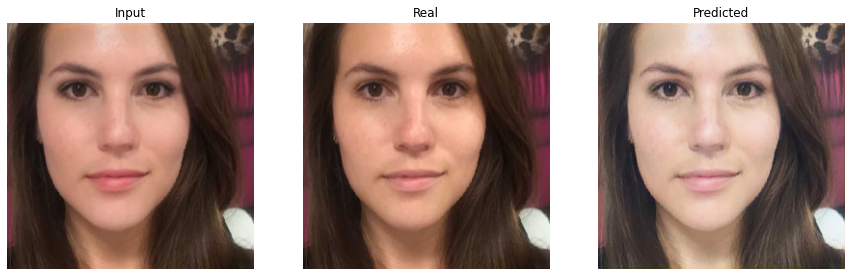

epoch: 1   loss: 5357.72119140625
-------- psnr:  19.266129    ----- epoch:  1   count:  100


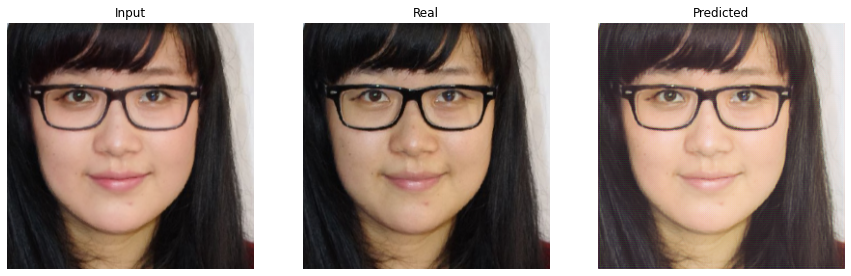

epoch: 2   loss: 3134.01806640625
-------- psnr:  19.56089    ----- epoch:  2   count:  100


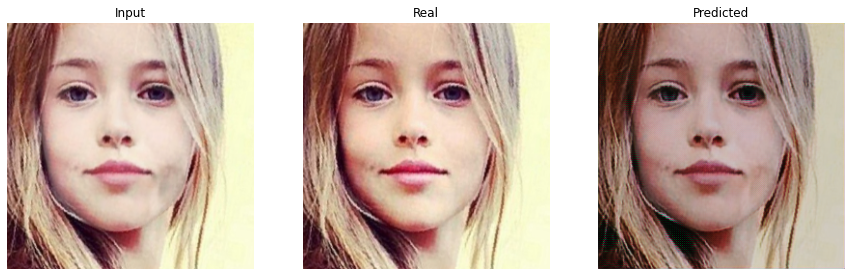

epoch: 3   loss: 2162.231201171875
-------- psnr:  19.834932    ----- epoch:  3   count:  100


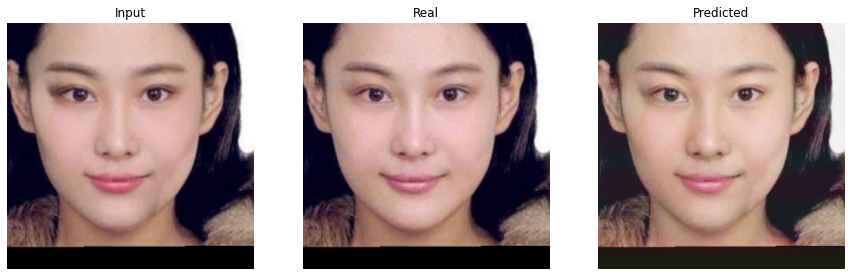

epoch: 4   loss: 1617.3128662109375
-------- psnr:  19.812017    ----- epoch:  4   count:  100
epoch: 5   loss: 1267.9161376953125
-------- psnr:  19.939241    ----- epoch:  5   count:  100


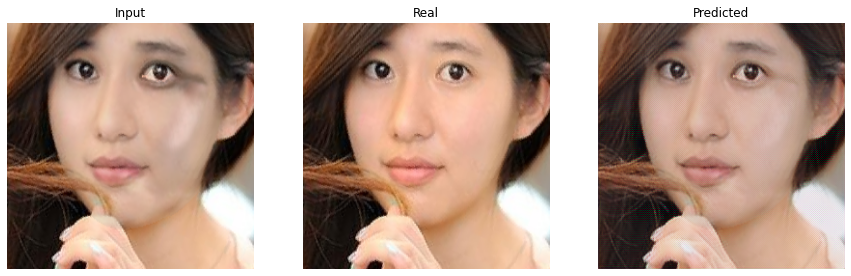

epoch: 6   loss: 1033.649169921875
-------- psnr:  19.914146    ----- epoch:  6   count:  100
epoch: 7   loss: 862.084228515625
-------- psnr:  20.040842    ----- epoch:  7   count:  100


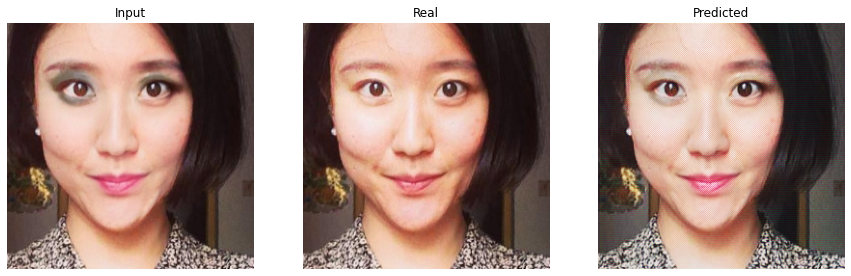

epoch: 8   loss: 732.6387939453125
-------- psnr:  20.273697    ----- epoch:  8   count:  100


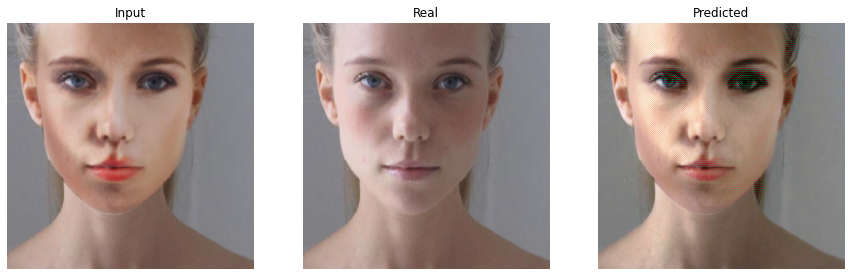

epoch: 9   loss: 633.8358764648438
-------- psnr:  20.399317    ----- epoch:  9   count:  100


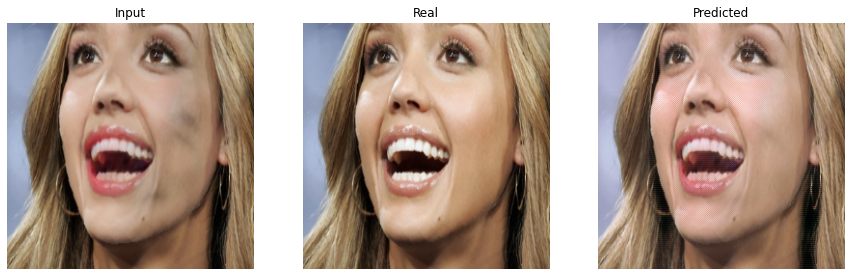

epoch: 10   loss: 549.0933837890625
-------- psnr:  20.535145    ----- epoch:  10   count:  100


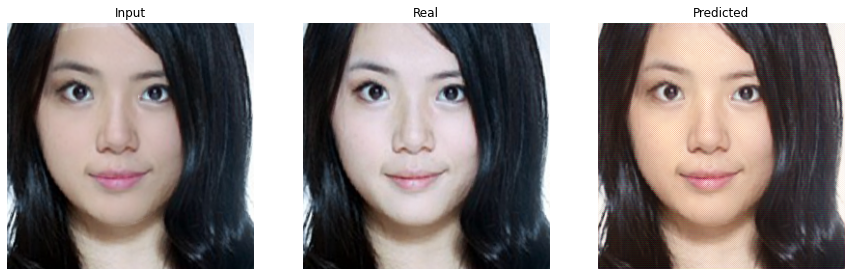

epoch: 11   loss: 486.7024230957031
-------- psnr:  20.64385    ----- epoch:  11   count:  100


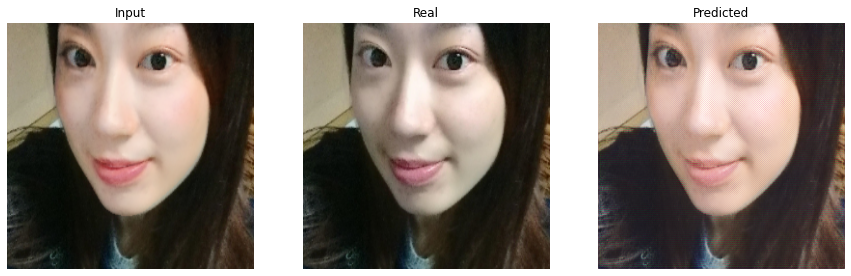

epoch: 12   loss: 427.57000732421875
-------- psnr:  20.744396    ----- epoch:  12   count:  100


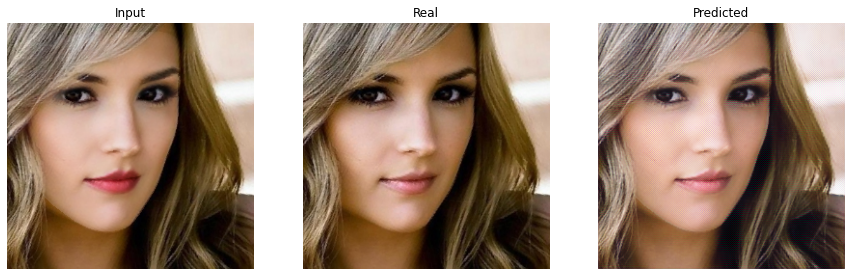

epoch: 13   loss: 381.8770446777344
-------- psnr:  20.271439    ----- epoch:  13   count:  100
epoch: 14   loss: 342.4607238769531
-------- psnr:  19.4851    ----- epoch:  14   count:  100


KeyboardInterrupt: ignored

In [25]:
EPOCHS = 50
fit(train_dataset, EPOCHS, val_dataset)

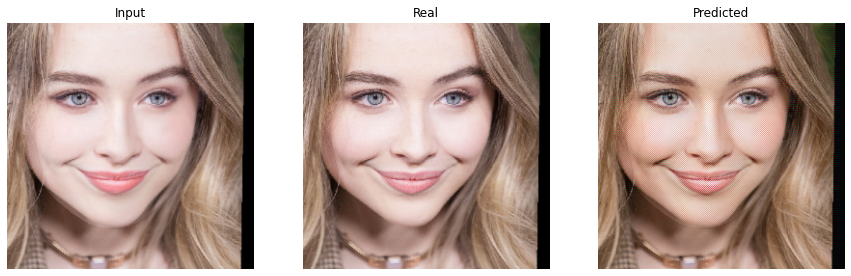

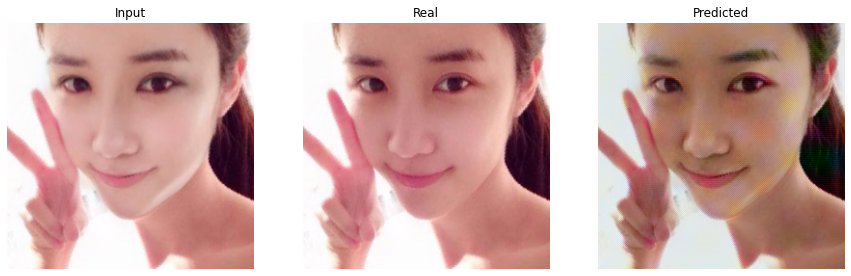

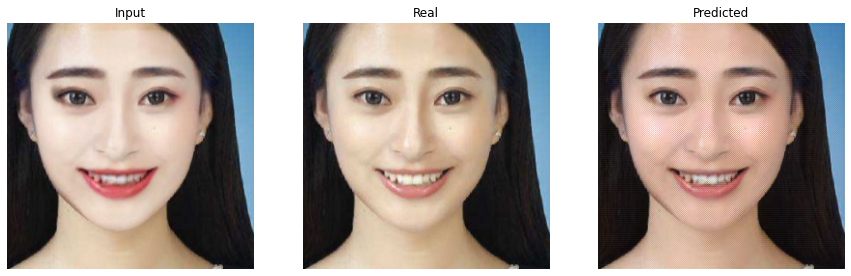

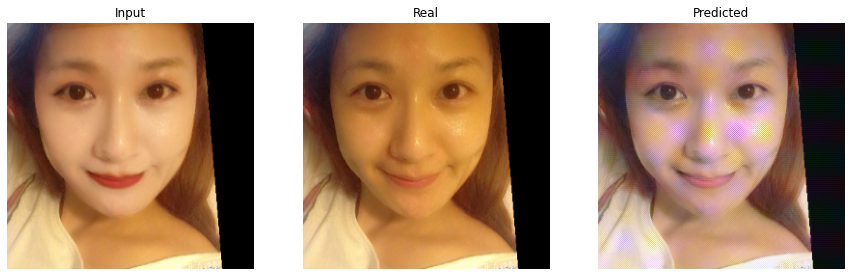

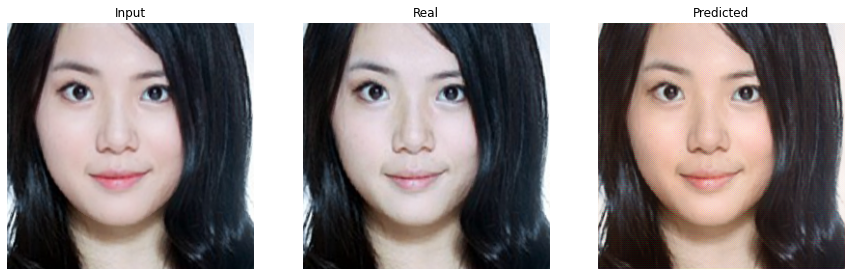

In [26]:
for _ in range(5):
    for inputs, targets in test_dataset.take(1):
        fake = res50Unet([inputs], training=True)
        plt.figure(figsize=(15,20))
        mean = np.array([103.939, 116.779, 123.68])
        mean = mean.reshape((1,1,3))
        a = inputs[0] + mean
        a = a[..., ::-1]
        
        display_list = [a/255, targets[0], fake[0]]
        title = ['Input', 'Real', 'Predicted']    

        
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show() 